# Demonstration of dql

In [1]:
import sys
sys.path.insert(0, '/Users/robertyi/repos/dataframe/dpipe')
from dpipe import *
from dpipe.sampledata.datagen import user_data, purchase_data
import dpipe as dp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Create some synthetic data
Let's start by making some synthetic data. Below I use some boilerplate numpy + pandas code to generate some weekly fluctuating revenue data.

In [2]:
users = user_data(1000, random_state=2701)
purchases = purchase_data(1000)

## Overview of data
We have two tables:

* `users`
* `purchases`

These should roughly mirror the kind of information companies will typically log (if star schema is being used) -- dimension tables describing *states*, such as a user information table; fact tables describing *events*, such as a purchases or visits table.

We'll assume we've loaded these as `pd.DataFrame`s from your data lake. Let's see how we would traditionally parse these.

## Plotting

Even for basic plotting of time trends, this can be quite cumbersome. Tools like superset and tableau make this significantly easier, but for data scientists who like to stay within the python ecosystem, substantial cleaning will nonetheless be required.

### Histograms

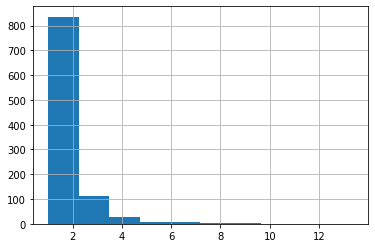

In [4]:
purchases.sale_value.hist()

Histograms are quite easy to plot, but typically some sort of log-scaling is necessary, especially for long-tailed distributions.

Iterations are usually required.

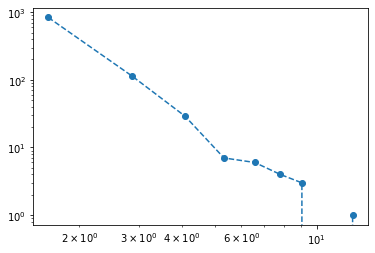

In [5]:
y, x = np.histogram(purchases.sale_value)
plt.plot((x[1:] + x[:-1])/2, y, 'o--')
plt.xscale('log')
plt.yscale('log')

`dpipe` makes this just as easy, but with a few small QOL improvements:

* Declarative syntax.
* Automatic ipython-suitable styling.
* Better defaults.

Moreover, the functions wrap matplotlib/pandas/numpy, so any arguments that apply to the base functions can be passed.

In [7]:
# We support dark mode (not on by default).
# Enabling it here because we like it.
import dpipe
dpipe.style.rc['style'] = 'dark_mode'

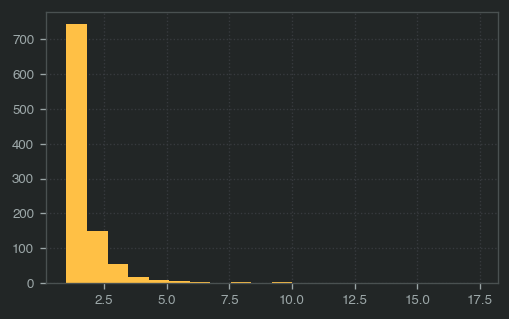

In [29]:
a = purchases.sale_value >> Hist(bins=20);

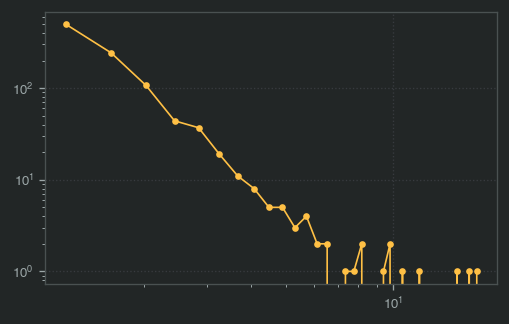

In [30]:
purchases.sale_value >> LogLogHist(bins=40)

## Scatter plots

In [6]:
a, b, c = np.array_split(users, 3)

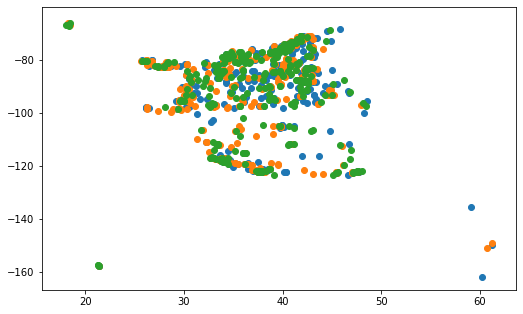

In [7]:
plt.figure(figsize=(8.5,5.2))
plt.scatter(a.lat, a.lng)
plt.scatter(b.lat, b.lng)
plt.scatter(c.lat, c.lng)

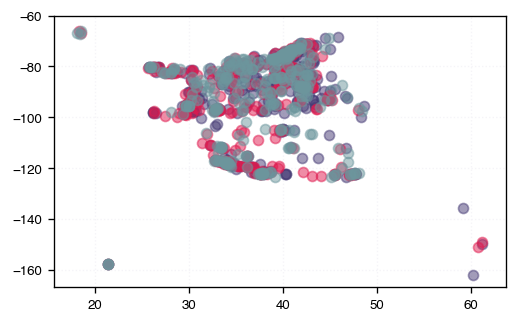

In [8]:
(a.lat, a.lng) >> Scatter
(b.lat, b.lng) >> Scatter()
(c.lat, c.lng) >> Scatter()

## Aggregations

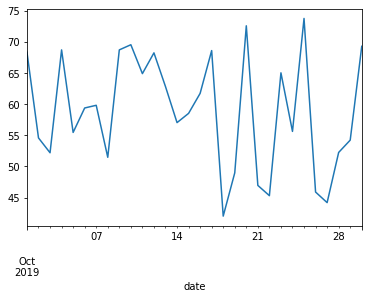

In [12]:
purchases_copy = purchases.copy()
purchases_copy['date'] = pd.to_datetime(purchases_copy.date)
gb = purchases_copy.groupby('date').sum()['sale_value']
gb.plot()

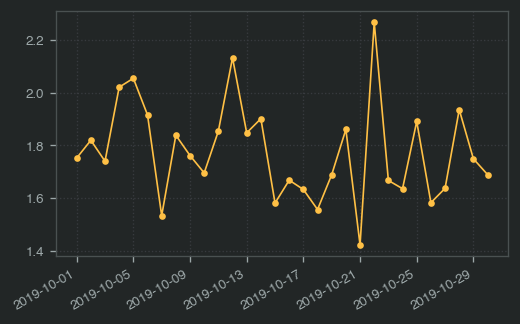

In [13]:
purchases >> GroupBy('date') >> Mean('sale_value') >> Plot

## Light mode

In [14]:
import dpipe
dpipe.style.rc['style'] = 'light_mode'

In [69]:
purchases.\
    copy().\
    sample(100)

,id_user,date,sale_value
290,479.0,2019-10-15,1.399290
338,37.0,2019-10-09,3.713701
476,743.0,2019-10-20,1.212790
875,15.0,2019-10-03,1.570736
982,391.0,2019-10-24,2.274818
...,...,...,...
413,639.0,2019-10-11,1.141261
854,481.0,2019-10-25,1.559687
867,34.0,2019-10-28,1.034297
602,715.0,2019-10-14,1.943337


In [22]:
purchases >> ConvertDatetimes

,id_user,date,sale_value
0,1970-01-01 00:00:00.000000866,2019-10-23,1970-01-01 00:00:00.000000001
1,1970-01-01 00:00:00.000000434,2019-10-19,1970-01-01 00:00:00.000000001
2,1970-01-01 00:00:00.000000427,2019-10-06,1970-01-01 00:00:00.000000002
3,1970-01-01 00:00:00.000000603,2019-10-26,1970-01-01 00:00:00.000000001
4,1970-01-01 00:00:00.000000843,2019-10-30,1970-01-01 00:00:00.000000002
...,...,...,...
995,1970-01-01 00:00:00.000000609,2019-10-08,1970-01-01 00:00:00.000000002
996,1970-01-01 00:00:00.000000411,2019-10-17,1970-01-01 00:00:00.000000001
997,1970-01-01 00:00:00.000000892,2019-10-13,1970-01-01 00:00:00.000000001
998,1970-01-01 00:00:00.000000378,2019-10-20,1970-01-01 00:00:00.000000001


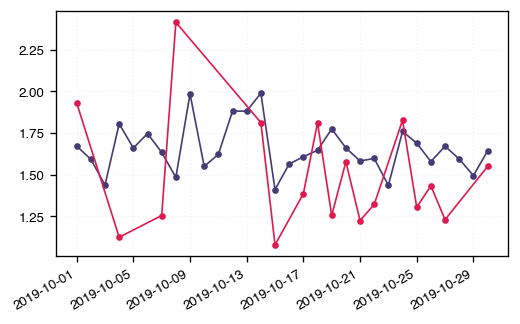

In [4]:
purchases >> ToDatetime('date') >> GroupBy('date') >> Mean('sale_value') >> Plot

new_purchases = purchases.sample(20, replace=True)
new_purchases >> GroupBy('date') >> Mean('sale_value') >> Plot

## ML

In [3]:
import numpy as np
import sklearn
df = pd.merge(users, purchases, on='id_user')
df = df[['population', 'density', 'sale_value']]
X = df[['population', 'density']]
y = df['sale_value']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)
print('Mean squared error:', sklearn.metrics.mean_squared_error(y_train, y_train_pred))
print('Mean absolute error:', sklearn.metrics.mean_absolute_error(y_train, y_train_pred))
print('Root mean squared error:', np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_pred)))
print('Mean squared error:', sklearn.metrics.mean_squared_error(y_test, y_pred))
print('Mean absolute error:', sklearn.metrics.mean_absolute_error(y_test, y_pred))
print('Root mean squared error:', np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred)))

Mean squared error: 0.415057954447655
Mean absolute error: 0.4355852780704066
Root mean squared error: 0.6442499161409763
Mean squared error: 0.3222090143126675
Mean absolute error: 0.41472521658976075
Root mean squared error: 0.5676345781510034


In [4]:
modelspec = (users, purchases) \
    >> Merge(on='id_user') \
    >> Select('population', 'density', 'sale_value') \
    >> InitModel(label='sale_value') \
    >> TrainTestSplit \
    >> LinearReg

Training set
------------ 
Max error: 1.9575069706263228
Mean absolute error: 0.3627445469998353
Mean squared error: 0.30102296838170994
Root mean squared error: 0.5486556008842979


Test set
-------- 
Max error: 1.6459247678860036
Mean absolute error: 0.6221389263797257
Mean squared error: 0.603869419261144
Root mean squared error: 0.777090354631393


In [14]:
modelspec = (users, purchases) \
    >> Merge(on='id_user') \
    >> Select('population', 'density', 'sale_value', 'city') \
    >> InitModel(label='sale_value') \
    >> LabelEnc(columns=['city']) \
    >> TrainTestSplit \
    >> LinearReg

Training set
------------ 
Max error: 1.713538271581803
Mean absolute error: 0.45830205655967043
Mean squared error: 0.41229994596960984
Root mean squared error: 0.6421058681943421


Test set
-------- 
Max error: 0.7890429651554134
Mean absolute error: 0.42212355506767063
Mean squared error: 0.23632292020259588
Root mean squared error: 0.4861305588034925
